# ETL con Pandas
**Materia:** Base de Datos II — ISPC  
**Alumno:** Cristian Bartolome Albarracin
**Cohorte/Año:** 2025

> Este notebook guía el proceso ETL: **Extract → Transform → Load**, más un **análisis exploratorio** y **carga a MySQL**.
> Dataset de ejemplo sugerido: “Sales and Customer data” (Kaggle). Descargue los archivos `customer_data.csv` y `sales_data.csv` al directorio `data/`.


## 0. Preparación del entorno
**Requisitos mínimos (ejecutar en la terminal/Anaconda Prompt):**
```bash
python -V
pip install pandas numpy matplotlib sqlalchemy pymysql python-dotenv
# Opcional: jupyterlab
pip install jupyterlab
```
Cree una carpeta `data/` junto a este notebook y coloque allí:
- `customer_data.csv`
- `sales_data.csv`


In [1]:
# 0. Imports y configuración básica
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Opcional: cargar variables de entorno (.env) con credenciales de BD
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception as e:
    print("dotenv no instalado o no se usará archivo .env:", e)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
DATA_DIR = 'data'  # cambie si corresponde
CUSTOMERS_CSV = os.path.join(DATA_DIR, 'customer_data.csv')
SALES_CSV = os.path.join(DATA_DIR, 'sales_data.csv')


## 1. Extracción (Extract)
Cargar los dos CSV en **dos DataFrames distintos** y **describir brevemente** cómo se realizó la extracción.


In [2]:
# 1.1 Carga de datos
customers_raw = pd.read_csv(CUSTOMERS_CSV)
sales_raw = pd.read_csv(SALES_CSV)

print("Customers shape:", customers_raw.shape)
print("Sales shape:", sales_raw.shape)

# 1.2 Inspección rápida
display(customers_raw.head(3))
display(customers_raw.info())
display(sales_raw.head(3))
display(sales_raw.info())

Customers shape: (99457, 4)
Sales shape: (99457, 7)


,customer_id,gender,age,payment_method
0,C241288,Female,28.00,Credit Card
1,C111565,Male,21.00,Debit Card
2,C266599,Male,20.00,Cash


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     99457 non-null  object 
 1   gender          99457 non-null  object 
 2   age             99338 non-null  float64
 3   payment_method  99457 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.0+ MB


None

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall
0,I138884,C241288,Clothing,5,"1,500.40",05-08-2022,Kanyon
1,I317333,C111565,Shoes,3,"1,800.51",12-12-2021,Forum Istanbul
2,I127801,C266599,Clothing,1,300.08,09-11-2021,Metrocity


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invoice_no     99457 non-null  object 
 1   customer_id    99457 non-null  object 
 2   category       99457 non-null  object 
 3   quantity       99457 non-null  int64  
 4   price          99457 non-null  float64
 5   invoice_date   99457 non-null  object 
 6   shopping_mall  99457 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 5.3+ MB


None

## 2. Transformación (Transform)
Limpieza y preparación (nulos, tipos de datos, formatos de fecha), y **unión por campo común** (ej.: `customer_id`).


In [3]:
# 2.1 Copias de trabajo (no borrar los originales)
customers = customers_raw.copy()
sales = sales_raw.copy()

# 2.2 Estandarización de nombres de columnas (opcional)
customers.columns = customers.columns.str.strip().str.lower().str.replace(' ', '_')
sales.columns = sales.columns.str.strip().str.lower().str.replace(' ', '_')

# 2.3 Conversión de tipos / fechas (ajuste los nombres según su dataset)
date_cols = [c for c in sales.columns if 'date' in c or 'fecha' in c]
for c in date_cols:
    sales[c] = pd.to_datetime(sales[c], errors='coerce')

# 2.4 Manejo de nulos (ejemplos)
# Rellenar género desconocido, o mantener NaN y documentar
if 'gender' in customers.columns:
    customers['gender'] = customers['gender'].str.strip().str.title()
    customers['gender'] = customers['gender'].replace({'F':'Female','M':'Male'}).fillna('Unknown')

# Edades negativas o fuera de rango -> NaN
if 'age' in customers.columns:
    customers['age'] = pd.to_numeric(customers['age'], errors='coerce')
    customers.loc[(customers['age'] < 0) | (customers['age'] > 120), 'age'] = np.nan

# Precios negativos -> NaN
for col in ['price','unit_price','amount','total']:
    if col in sales.columns:
        sales[col] = pd.to_numeric(sales[col], errors='coerce')
        sales.loc[sales[col] < 0, col] = np.nan

# 2.5 Merge por id de cliente (ajuste el nombre exacto)
merge_key_candidates = [c for c in customers.columns if 'id' in c]
merge_key_candidates_sales = [c for c in sales.columns if 'id' in c]
print("Posibles llaves en customers:", merge_key_candidates)
print("Posibles llaves en sales:", merge_key_candidates_sales)

# Supongamos que es 'customer_id' en ambos
key = 'customer_id' if 'customer_id' in customers.columns and 'customer_id' in sales.columns else merge_key_candidates[0]
df = sales.merge(customers, how='left', on=key)

print("DF final (post-merge):", df.shape)
display(df.head(3))

Posibles llaves en customers: ['customer_id']
Posibles llaves en sales: ['customer_id']
DF final (post-merge): (99457, 10)


,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,gender,age,payment_method
0,I138884,C241288,Clothing,5,"1,500.40",2022-05-08,Kanyon,Female,28.00,Credit Card
1,I317333,C111565,Shoes,3,"1,800.51",2021-12-12,Forum Istanbul,Male,21.00,Debit Card
2,I127801,C266599,Clothing,1,300.08,2021-09-11,Metrocity,Male,20.00,Cash


### 2.6 Transformaciones específicas pedidas
- **Modo de pago más frecuente (global y por género)**  
- **Categorización de clientes por forma de pago, edad y género**  
- **Métodos de pago en rango etario 25–35**  
- **Métodos de pago más usados por mujeres**  
- **Precios por categoría de producto**


In [4]:
# 2.6.1 Modo de pago (global y por género)
pay_col = 'payment_method' if 'payment_method' in df.columns else None
genre_col = 'gender' if 'gender' in df.columns else None

if pay_col:
    moda_global = df[pay_col].mode(dropna=True)
    print("Modo de pago GLOBAL:", moda_global.iloc[0] if not moda_global.empty else None)

    if genre_col:
        moda_por_genero = df.groupby(genre_col)[pay_col]                            .agg(lambda s: s.mode(dropna=True).iloc[0] if not s.mode(dropna=True).empty else None)                            .reset_index(name='payment_mode_top')
        display(moda_por_genero)
else:
    print("No se encontró la columna de método de pago; ajuste el nombre en el código.")

Modo de pago GLOBAL: Cash


,gender,payment_mode_top
0,Female,Cash
1,Male,Cash


In [5]:
# 2.6.2 Categorización por forma de pago, edad y género
def categorizar_edad(a):
    if pd.isna(a): return 'Desconocida'
    a = int(a)
    if a < 18: return '<18'
    if 18 <= a <= 24: return '18-24'
    if 25 <= a <= 35: return '25-35'
    if 36 <= a <= 50: return '36-50'
    return '51+'

if 'age' in df.columns:
    df['age_group'] = df['age'].apply(categorizar_edad)
else:
    df['age_group'] = 'Desconocida'

if pay_col and genre_col:
    cat_resumen = (df
        .groupby([genre_col,'age_group',pay_col], dropna=False)
        .size()
        .reset_index(name='conteo'))
    display(cat_resumen.sort_values('conteo', ascending=False).head(20))

,gender,age_group,payment_method,conteo
9,Female,51+,Cash,9712
6,Female,36-50,Cash,7722
10,Female,51+,Credit Card,7578
24,Male,51+,Cash,6457
7,Female,36-50,Credit Card,6172
3,Female,25-35,Cash,5521
21,Male,36-50,Cash,5159
25,Male,51+,Credit Card,5082
4,Female,25-35,Credit Card,4401
11,Female,51+,Debit Card,4297


In [6]:
# 2.6.3 Métodos de pago rango 25–35
if pay_col and 'age' in df.columns:
    rango_2535 = df[(df['age'] >= 25) & (df['age'] <= 35)]
    pagos_2535 = rango_2535[pay_col].value_counts(dropna=True).reset_index()
    pagos_2535.columns = ['payment_method','conteo']
    display(pagos_2535)


,payment_method,conteo
0,Cash,9356
1,Credit Card,7274
2,Debit Card,4263


In [7]:
# 2.6.4 Métodos de pago más usados por mujeres
if pay_col and genre_col:
    mujeres = df[df[genre_col].str.lower().eq('female')]
    pagos_mujeres = mujeres[pay_col].value_counts(dropna=True).reset_index()
    pagos_mujeres.columns = ['payment_method','conteo']
    display(pagos_mujeres)

,payment_method,conteo
0,Cash,26509
1,Credit Card,21011
2,Debit Card,11962


In [8]:
# 2.6.5 Precios por categoría de producto
cat_col = None
for candidate in ['category','product_category','categoria','product_type']:
    if candidate in df.columns:
        cat_col = candidate
        break

price_col = None
for candidate in ['price','unit_price','amount','total']:
    if candidate in df.columns:
        price_col = candidate
        break

if cat_col and price_col:
    precios_cat = df.groupby(cat_col)[price_col].agg(['count','min','max','mean','median']).reset_index()
    display(precios_cat)
else:
    print("Verifique nombres de columna para categoría y precio.")

,category,count,min,max,mean,median
0,Books,4981,15.15,75.75,45.57,45.45
1,Clothing,34487,300.08,"1,500.40",901.08,900.24
2,Cosmetics,15097,40.66,203.30,122.45,121.98
3,Food & Beverage,14776,5.23,26.15,15.67,15.69
4,Shoes,10034,600.17,"3,000.85","1,807.39","1,800.51"
5,Souvenir,4999,11.73,58.65,34.89,35.19
6,Technology,4996,"1,050.00","5,250.00","3,156.94","3,150.00"
7,Toys,10087,35.84,179.20,107.73,107.52


## 3. Limpieza (Load → “datos limpios”)
Crear un **DataFrame final** con las columnas necesarias para análisis posteriores y guardarlo a disco.


In [9]:
# 3.1 Selección de columnas 'curadas' (ajuste según su dataset)
keep_cols = [c for c in df.columns if c in [
    'customer_id','age','age_group','gender','payment_method',
    'order_id','order_date','product_id','product_name','category',
    'quantity','price','unit_price','amount','total'
] or c.endswith('_date')]

clean = df[keep_cols].copy()

# 3.2 Opcional: eliminar filas con datos críticos faltantes
# clean = clean.dropna(subset=['customer_id','order_id'])

# 3.3 Guardar dataset limpio
os.makedirs('outputs', exist_ok=True)
clean_path = os.path.join('outputs','etl_clean.csv')
clean.to_csv(clean_path, index=False, encoding='utf-8')
clean_path

'outputs\\etl_clean.csv'

## 4. Carga a MySQL y consultas SQL
> Opción A: usar `pandas.to_sql` (rápido para tablas pequeñas).  
> Opción B: crear tabla y usar `LOAD DATA INFILE` desde el servidor.


In [ ]:
# 4.1 Conexión con SQLAlchemy 
DB_USER = os.getenv('DB_USER', 'root')
DB_PASS = os.getenv('DB_PASS', '329158')
DB_HOST = os.getenv('DB_HOST', '127.0.0.1')
DB_PORT = os.getenv('DB_PORT', '3306')
DB_NAME = os.getenv('DB_NAME', 'etl_ventas')

from sqlalchemy import create_engine, text
engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/", echo=False, future=True)

# 4.2 Crear base de datos si no existe (requiere permisos)
with engine.begin() as conn:
    conn.exec_driver_sql(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}")
    conn.exec_driver_sql(f"USE {DB_NAME}")

In [16]:
engine_root = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/", echo=False, future=True)
with engine_root.begin() as conn:
    conn.exec_driver_sql(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}")

engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}", echo=False, future=True)


In [17]:
# 4.3 Cargar DataFrame 'clean' a una tabla (sobrescribe si existe)
table_name = 'ventas_clientes_clean'
clean.to_sql(name=table_name, con=engine_root, schema=DB_NAME, if_exists="replace", index=False)
print("Tabla creada/cargada:", table_name)

Tabla creada/cargada: ventas_clientes_clean


In [18]:
# 4.4 Consultas SQL ejemplo (ajuste nombres según su dataset)
sql_queries = {
    "modo_pago_global": "SELECT payment_method, COUNT(*) AS conteo FROM ventas_clientes_clean GROUP BY payment_method ORDER BY conteo DESC LIMIT 1;",
    "modo_pago_por_genero": "SELECT gender, payment_method, COUNT(*) AS conteo FROM ventas_clientes_clean GROUP BY gender, payment_method ORDER BY gender, conteo DESC;",
    "pagos_25_35": "SELECT payment_method, COUNT(*) AS conteo FROM ventas_clientes_clean WHERE age BETWEEN 25 AND 35 GROUP BY payment_method ORDER BY conteo DESC;",
    "pagos_mujeres": "SELECT payment_method, COUNT(*) AS conteo FROM ventas_clientes_clean WHERE LOWER(gender)='female' GROUP BY payment_method ORDER BY conteo DESC;",
    "precios_por_categoria": "SELECT category, COUNT(*) AS n, MIN(price) AS min_p, MAX(price) AS max_p, AVG(price) AS avg_p FROM ventas_clientes_clean GROUP BY category ORDER BY category;"
}

with engine.begin() as conn:
    for k,q in sql_queries.items():
        print(f"\n-- {k}")
        try:
            res = conn.execute(text(q)).fetchmany(5)  # muestra 5 filas por consulta
            for row in res:
                print(dict(row._mapping))
        except Exception as e:
            print("Error en consulta", k, ":", e)


-- modo_pago_global
{'payment_method': 'Cash', 'conteo': 44447}

-- modo_pago_por_genero
{'gender': 'Female', 'payment_method': 'Cash', 'conteo': 26509}
{'gender': 'Female', 'payment_method': 'Credit Card', 'conteo': 21011}
{'gender': 'Female', 'payment_method': 'Debit Card', 'conteo': 11962}
{'gender': 'Male', 'payment_method': 'Cash', 'conteo': 17938}
{'gender': 'Male', 'payment_method': 'Credit Card', 'conteo': 13920}

-- pagos_25_35
{'payment_method': 'Cash', 'conteo': 9356}
{'payment_method': 'Credit Card', 'conteo': 7274}
{'payment_method': 'Debit Card', 'conteo': 4263}

-- pagos_mujeres
{'payment_method': 'Cash', 'conteo': 26509}
{'payment_method': 'Credit Card', 'conteo': 21011}
{'payment_method': 'Debit Card', 'conteo': 11962}

-- precios_por_categoria
{'category': 'Books', 'n': 4981, 'min_p': 15.15, 'max_p': 75.75, 'avg_p': 45.56862075888369}
{'category': 'Clothing', 'n': 34487, 'min_p': 300.08, 'max_p': 1500.4, 'avg_p': 901.0840212250755}
{'category': 'Cosmetics', 'n': 1509

## 5. Análisis exploratorio breve (EDA)
Gráficos simples con `matplotlib` (no especificamos colores).


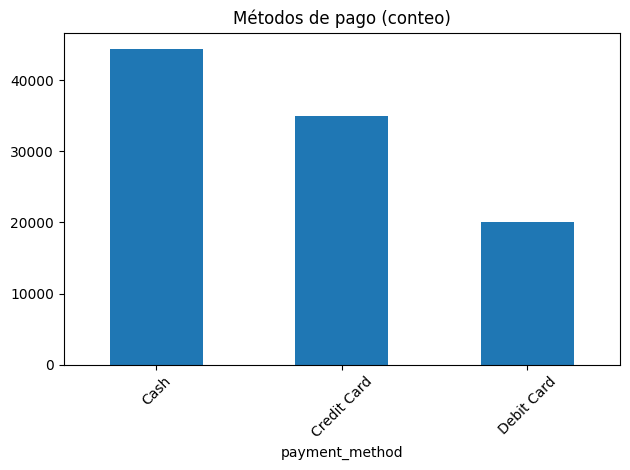

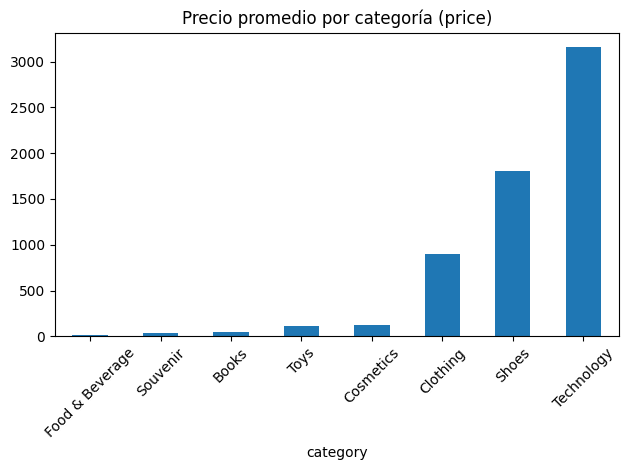

In [19]:
# Distribución de métodos de pago
if 'payment_method' in clean.columns:
    ax = clean['payment_method'].value_counts().plot(kind='bar', rot=45, title='Métodos de pago (conteo)')
    plt.tight_layout()
    plt.show()

# Precios por categoría (promedios)
if 'category' in clean.columns and ('price' in clean.columns or 'unit_price' in clean.columns):
    price_col = 'price' if 'price' in clean.columns else 'unit_price'
    grp = clean.groupby('category')[price_col].mean().sort_values()
    grp.plot(kind='bar', rot=45, title=f'Precio promedio por categoría ({price_col})')
    plt.tight_layout()
    plt.show()

## 6. Exportables
- `outputs/etl_clean.csv` (datos limpios)
- Copie y pegue gráficos/valores en su informe.
- Agregue capturas del notebook ejecutado (celdas de código + salida).
